This jupyter notebook contains demo code for:
- loading a model and using it to drive one or more source frames with audio features

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os
import torch
from PIL import Image
from torch.autograd import Variable
from UnwrappedFace import UnwrappedFaceWeightedAverage, BottleneckFromNet
from sklearn.externals import joblib
from torchvision.transforms import Compose, Scale, ToTensor

/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def load_img_and_audio(file_path):
    transform = Compose([Scale((256,256)), ToTensor()])
    img = Image.open(file_path).convert('RGB')
    img = transform(img)
    audio_label_path = str(file_path).replace('audio_faces', 'audio_features').replace('jpg','npz')
    audio_feature = torch.Tensor(np.load(audio_label_path)['audio_feat'])
    return {'image' : img, 'audio' : audio_feature}

**Loading models**

In [3]:
# paths to source frames
sourcepaths= ['examples/audio_faces/Retta/1.6/ALELNl9E1Jc/0002725.jpg',
                'examples/audio_faces/Maya_Rudolph/1.6/Ylm6PVkbwhs/0004500.jpg', 
               'examples/audio_faces/Cristin_Milioti/1.6/IblJpk1GDZA/0004575.jpg']

# path to frames corresponding to driving audio features
audio_path = 'examples/audio_faces/Peter_Capaldi/1.6/uAgUjSqIj7U'
imgpaths = os.listdir(audio_path)

# loading models
BASE_MODEL = './release_models/' # Change to your path
model_path = BASE_MODEL + 'x2face_model_forpython3.pth'
model = UnwrappedFaceWeightedAverage(output_num_channels=2, input_num_channels=3,inner_nc=128)
model.load_state_dict(torch.load(model_path)['state_dict'])

s_dict = torch.load(model_path)
modelfortargetpose = BottleneckFromNet()
state = modelfortargetpose.state_dict()
s_dict = {k: v for k, v in s_dict['state_dict'].items() if k in state.keys()}
state.update(s_dict)
modelfortargetpose.load_state_dict(state)

posemodel = nn.Sequential(nn.Linear(128, 3))
p_dict_pre = torch.load(BASE_MODEL + '/posereg_forpython3.pth')['state_dict']
posemodel._modules['0'].weight.data = p_dict_pre['posefrombottle.weight'].cpu()
posemodel._modules['0'].bias.data = p_dict_pre['posefrombottle.bias'].cpu()

bottleneckmodel = nn.Sequential(nn.Linear(3, 128, bias=False), nn.BatchNorm1d(128))
b_dict_pre = torch.load(BASE_MODEL + '/posetobottle_forpython3.pth')['state_dict']
bottleneckmodel.load_state_dict(b_dict_pre)

model = model.cuda()
modelfortargetpose = modelfortargetpose.cuda()
posemodel = posemodel.cuda()
bottleneckmodel = bottleneckmodel.cuda()

model.eval()
modelfortargetpose.eval()
posemodel.eval()
bottleneckmodel.eval()

# load linear regression from audio features to driving vector space
linearregression = joblib.load(BASE_MODEL + '/linearregression_scaledTrue_7000.pkl')
scalar = joblib.load(BASE_MODEL + '/scaler_7000.pkl')
scalar = None

initialization method [xavier]


/users/koepke/coding/conferences/X2Face/UnwrapMosaic/SkipNet.py:72: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data, gain=1)
/users/koepke/coding/conferences/X2Face/UnwrapMosaic/SkipNet.py:76: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  init.uniform(m.weight.data, 0.02, 1)
/users/koepke/coding/conferences/X2Face/UnwrapMosaic/SkipNet.py:77: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


initialization method [xavier]


/users/koepke/coding/conferences/X2Face/UnwrapMosaic/NoSkipNet_X2Face.py:32: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data, gain=1)
/users/koepke/coding/conferences/X2Face/UnwrapMosaic/NoSkipNet_X2Face.py:36: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  init.uniform(m.weight.data, 1.0, 0.02)
/users/koepke/coding/conferences/X2Face/UnwrapMosaic/NoSkipNet_X2Face.py:37: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


initialization method [xavier]


/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


**Code for driving image generation with audio features**

/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/si

/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/si

/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/site-packages/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/scratch/local/ssd/koepke/local/anaconda3/envs/oldx2face_37/lib/python3.7/si

Top row: Frames corresponding to driving audio
Bottom 3 rows: generated frames driven with audio features corresponding to top row


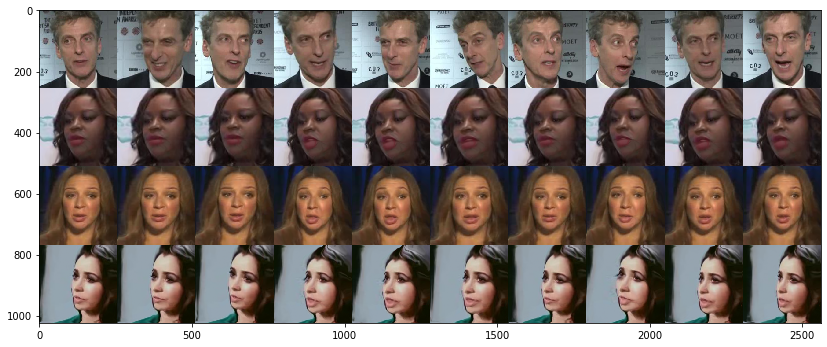

In [4]:
# Drive 3 different identities with same audio
img_gt_gen = np.empty((0,2560,3))
with torch.no_grad():
    for sourcepath in sourcepaths:
        img_to_show_all = np.empty((256,0,3))
        gt_ims = np.empty((256,0,3))
        source_data = load_img_and_audio(sourcepath)
        source_img = Variable(source_data['image']).cuda().unsqueeze(0)
        audio_feature_source = source_data['audio'].cpu().numpy().reshape(1,-1)
        audio_feature_origin = linearregression.predict(audio_feature_source)
        audio_feature_origin = torch.Tensor(audio_feature_origin).unsqueeze(2).unsqueeze(2)
        for imgpath in imgpaths:
            # Extract the driving audio features
            fullaudiopath = os.path.join(audio_path, imgpath)
            audio_data = load_img_and_audio(fullaudiopath)
            audio_img = Variable(audio_data['image']).cuda().unsqueeze(0)
            audio_feature = audio_data['audio'].cpu().numpy().reshape(1,-1)
            if not scalar is None:
                audio_feature = scalar.transform(audio_feature)
                audio_feature_origin = scalar.transform(audio_feature_origin)
            audio_feature = linearregression.predict(audio_feature)
            audio_feature = torch.Tensor(audio_feature).unsqueeze(2).unsqueeze(2)
        
            sourcebn = modelfortargetpose(source_img)
            sourcepose = posemodel(sourcebn.unsqueeze(0))
            sourceposebn = bottleneckmodel(sourcepose)
    
            def update_bottleneck(self, input, output):
                newdrive = sourcebn.unsqueeze(0).unsqueeze(2).unsqueeze(3) + Variable(audio_feature).cuda() - Variable(audio_feature_origin).cuda()
                audiopose =  posemodel(newdrive.squeeze().unsqueeze(0)) #
                audioposebn = bottleneckmodel(audiopose)
                output[0,:,:,:] = newdrive + sourceposebn.unsqueeze(2).unsqueeze(3) - audioposebn.unsqueeze(2).unsqueeze(3) # if we want to add old pose (of input) and substract pose info that's in the new bottleneck

            # Add a forward hook to update the model's bottleneck
            handle = model.pix2pixSampler.netG.model.submodule.submodule.submodule.submodule.submodule.submodule.submodule.down[1].register_forward_hook(update_bottleneck)
            result = model(source_img, source_img)
            handle.remove()
            img_to_show_all = np.hstack((result.squeeze().cpu().data.permute(1,2,0).numpy(), img_to_show_all))
            if img_gt_gen.shape == (0,2560,3):
                gt_ims = np.hstack((audio_img.squeeze().cpu().data.permute(1,2,0).numpy(), gt_ims))
        if img_gt_gen.shape == (0,2560,3):
            img_gt_gen = np.vstack((img_gt_gen, gt_ims))
        img_gt_gen = np.vstack((img_gt_gen, img_to_show_all))
plt.rcParams["figure.figsize"] = [14,14]
plt.imshow(img_gt_gen)
print('Top row: Frames corresponding to driving audio')
print('Bottom 3 rows: generated frames driven with audio features corresponding to top row')